In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).




*   The pickle file with the projections for choice 1 (i.e. beta estimates) is [in this link](https://drive.google.com/file/d/1-gZuEAdYaIEfFa1ZLNU-wYnxKQ5w_L_A/view?usp=sharing)
*   The pickle file with the projections for choice 2 (i.e. alpha estimates for trimmed stable) is [in this link](https://drive.google.com/file/d/1-8picdFCUIyxAD5AYBbnnL3aJhplGr0c/view?usp=sharing)
*   The pickle file with the projections for choice 3 (i.e. alpha estimates for Y distribution) is [in this link](https://drive.google.com/file/d/1NqhCGX9TPLOc082Heg0TOVnk5vLcV_Ys/view?usp=sharing)








In this script, you can choose one of three distributions whose parameter is estimated:



*   If you choose 1 in the input value, the parameter $\beta$ of $S_{1.5}(1.9,\beta,10)$
*   If you choose 2 in the input value, the parameter $\alpha$ of $Z$ will be estimated where if defined as follows $Z = \max\{ -\frac{6}{\alpha},\min\{X, \frac{6}{\alpha} \}\}$ and $X\sim S_{\alpha}(1,0,0)$. In other words, $Z$ is a clipped stable distribution. 
*   If you choose 3 in the input value, the parameter $\alpha$ of $Y$ will be estimated where if defined as follows:
$$ Y = \frac{(P_1-P_2)}{P_3}\cdot \sqrt{|S|}+L\text{ where }P_1,P_2,P_3\sim \mathrm{Pareto}(\alpha, 1), S\sim S_{\alpha}(1,0,0),L\sim \mathrm{Logistic}(\alpha, 0)$$
They are all independent, i.e. all of the random variables $P_1, P_2, P_3, S, L$ are independent of one another.

For choice 1, the alpha is chosen to be 1.5 because the lowest value of the Fisher information of $\alpha$ for $S_{\alpha}(1,0,0)$ is around 1.5. The following graph demonstrates the estimation of the Fisher information using different values of $\mathbf{T}$:


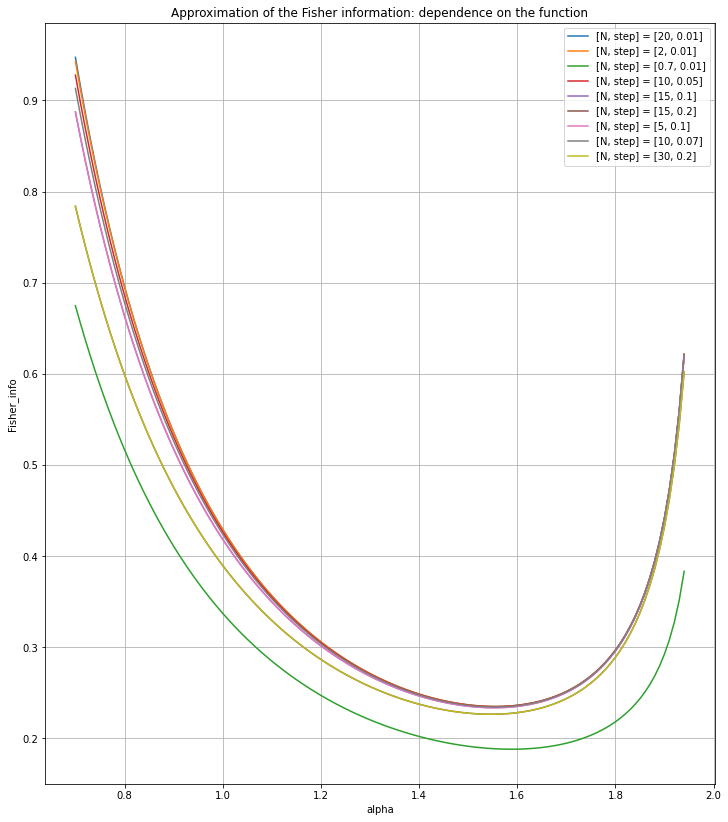

In [ ]:
def get_input():
    while True:
        try:
            print('choice = 1: estimation of the beta parameter of a stable distribution')
            print('choice = 2: estimation of the alpha parameter of a clipped stable distribution')
            print('choice = 3: estimation of the alpha parameter of the Y distribution mentioned in the report')
            choice = int(input("Enter a number (1, 2, or 3): "))
            if choice not in [1, 2, 3]:
                print("Invalid input. Please enter 1, 2, or 3.")
                continue
            else:
                return choice
        except ValueError:
            print("Invalid input. Please enter a valid number.")


In [ ]:
# the choice of the distribution
stor_j = get_input() - 1

choice = 1: estimation of the beta parameter of a stable distribution
choice = 2: estimation of the alpha parameter of a clipped stable distribution
choice = 3: estimation of the alpha parameter of the Y distribution mentioned in the report
Enter a number (1, 2, or 3): 1


In [ ]:
storage = ['pickle_beta_stable', 'pickle_trimmed_stable', 'pickle_Y_dist']


file_path = '/content/drive/MyDrive/pickle_file.'+storage[stor_j]

# Load data from file
with open(file_path, 'rb') as handle:
    loaded_data = pickle.load(handle)

In [ ]:
# importing the packages that will be used in this code
import numpy as np                   # for the operations with matrices and vectors
import matplotlib.pyplot as plt      # for visualizations
from scipy.stats import levy_stable  # for generating samples from S_{\alpha}(1,0,0)

In [ ]:
def simulate_sample1(alpha, N):
    mu = 0
    sigma = 1
    X = levy_stable.rvs(alpha, 0, loc=mu, scale=1, size=N)
    Y = np.clip(X, -6/alpha, 6/alpha)
    return Y

def simulate_sample2(alpha1, N):
    X1 = np.random.pareto(2, N)
    X2 = np.random.pareto(2, N)
    mu = 1.9
    sigma = 10
    #X3 = levy_stable.rvs(1.5, alpha1, size=N)
    X3 = levy_stable.rvs(1.5, alpha1, loc=mu, scale=1, size=N)
    return (X1 - X2)*np.abs(X3)


def simulate_sample3(alpha, N):
    X1 = np.random.pareto(alpha, N)
    X2 = np.random.pareto(alpha, N)
    X3 = np.random.pareto(2*alpha, N)
    X4 = np.sqrt(np.abs(levy_stable.rvs(alpha, 0, size=N)))
    X5 = np.random.logistic(loc=0, scale=alpha, size=N)
    return (X1 - X2)/X3*X4 + X5

simulation_functions = {'pickle_beta_stable': simulate_sample2, 'pickle_trimmed_stable': simulate_sample1,'pickle_Y_dist': simulate_sample3}
parameter_vals_for_error_function = {'pickle_beta_stable': 0.7, 'pickle_trimmed_stable': 1.7,'pickle_Y_dist': 1.8}
simulate_sample = simulation_functions[storage[stor_j]]

In [ ]:
T = loaded_data['T']
Alphas = loaded_data['alpha_values']
projection_vectors = loaded_data['projections']

In [ ]:
def truncate_string(num):
    num = round(num, 4)
    num = str(num)
    new_string = num[:6]
    return new_string + "0" * (6 - len(new_string))

In [ ]:
def F(X, T):
    X1 = np.outer(X, T)
    Y1 = np.cos(X1)
    FX = np.mean(Y1, axis=0)
    return 2*FX

In [ ]:
def visualize_samples(values_of_alpha, Means, upper_line, lower_line, N):      
      fig = plt.figure(figsize=(9, 9))
      plt.plot(values_of_alpha, Means, 'g-o')
      plt.plot(values_of_alpha, upper_line, 'b')
      plt.plot(values_of_alpha, lower_line, 'r')
      plt.plot(values_of_alpha, values_of_alpha, 'k')
      plt.fill_between(values_of_alpha, upper_line, lower_line, color='gray', alpha=0.5)
      plt.grid()
      plt.xlabel('alpha')
      plt.ylabel('alpha_estimate')
      plt.title(r'Demonstration of the average estimate and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))
      plt.legend(['$\mu$,  $\mu = avg(alpha\_sample)$','$ \mu + 3*\sigma$,  $\sigma = std(alpha\_sample)$', '$\mu - 3*\sigma$',  'real_alpha'])
      #plt.ylim([0.8, 2.2])

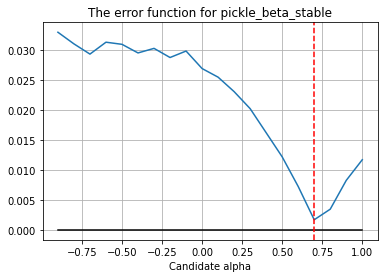

In [ ]:
#Visualization of the error function
N = 10000
alpha = parameter_vals_for_error_function[storage[stor_j]]
X = simulate_sample(alpha, N)
FX = F(X, T)

y = []
y1 = []
for k in Alphas:
    y1.append(np.dot(FX, projection_vectors[k]))
plt.plot(Alphas, np.abs(y1))
plt.plot(Alphas, np.array(y1)*0,'k')
plt.axvline(x=alpha, color='red', linestyle='--')
plt.grid()
plt.title('The error function for '+storage[stor_j])
plt.xlabel('Candidate alpha')
plt.show()


In [ ]:
def truncate_string(num):
    num = round(num, 4)
    num = str(num)
    new_string = num[:6]
    return new_string + "0" * (6 - len(new_string))

In [ ]:
sample_sizes = [150, 5000, 20000, 100000] 

In [ ]:
def simulate_and_estimate(N, num_samples, projection_vectors, T, Alphas, verbose):
    Avg_Alpha_Estimates_e = []
    Std_Alpha_Estimates_e = []

    for alpha in Alphas:
        Ests_e = []
        for _ in range(num_samples):

            X = simulate_sample(alpha, N)
            FX = F(X, T)

            y_e = []

            for k in Alphas:
                y_e.append(abs(np.dot(FX, projection_vectors[k])))    

            argmin_e = np.argmin(y_e) 

            alpha_est_e = Alphas[argmin_e]

            Ests_e.append(alpha_est_e)

        Avg_Alpha_Estimates_e.append(np.mean(Ests_e))
        Std_Alpha_Estimates_e.append(np.std(Ests_e))
        if verbose:
            print(f"Target alpha = {truncate_string(alpha)}, avg alpha_MLP_e = {truncate_string(np.mean(Ests_e))} ")  
    return Avg_Alpha_Estimates_e, Std_Alpha_Estimates_e

In [ ]:
N = 8000
num_samples = 50

Avg_Alpha_Estimates_e, Std_Alpha_Estimates_e = \
simulate_and_estimate(N, num_samples, projection_vectors, T, Alphas, 1)

Target alpha = -0.900, avg alpha_MLP_e = -0.854 
Target alpha = -0.800, avg alpha_MLP_e = -0.808 
Target alpha = -0.700, avg alpha_MLP_e = -0.712 
Target alpha = -0.600, avg alpha_MLP_e = -0.630 
Target alpha = -0.500, avg alpha_MLP_e = -0.496 
Target alpha = -0.400, avg alpha_MLP_e = -0.398 
Target alpha = -0.300, avg alpha_MLP_e = -0.290 
Target alpha = -0.200, avg alpha_MLP_e = -0.196 
Target alpha = -0.100, avg alpha_MLP_e = -0.110 
Target alpha = -0.000, avg alpha_MLP_e = 0.0180 
Target alpha = 0.1000, avg alpha_MLP_e = 0.0900 
Target alpha = 0.2000, avg alpha_MLP_e = 0.1980 
Target alpha = 0.3000, avg alpha_MLP_e = 0.2820 
Target alpha = 0.4000, avg alpha_MLP_e = 0.4080 
Target alpha = 0.5000, avg alpha_MLP_e = 0.5080 
Target alpha = 0.6000, avg alpha_MLP_e = 0.5980 
Target alpha = 0.7000, avg alpha_MLP_e = 0.7000 
Target alpha = 0.8000, avg alpha_MLP_e = 0.8120 
Target alpha = 0.9000, avg alpha_MLP_e = 0.8960 
Target alpha = 1.0000, avg alpha_MLP_e = 0.9820 


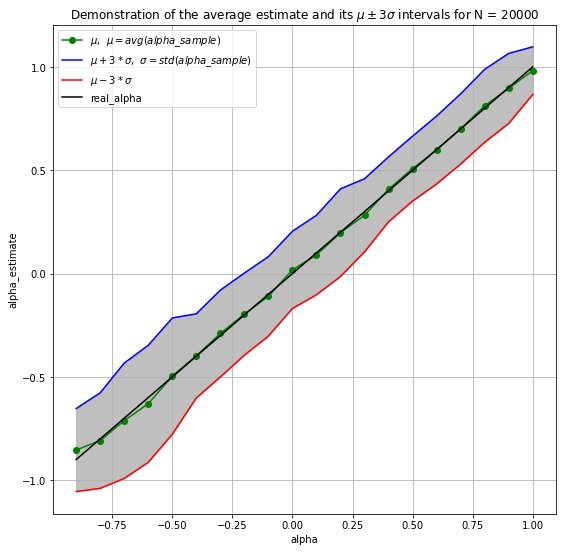

In [ ]:
N = sample_sizes[2]
values_of_alpha = Alphas
Means_100000 = Avg_Alpha_Estimates_e
upper_line_100000 = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line_100000 = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means_100000, upper_line_100000, lower_line_100000, N)

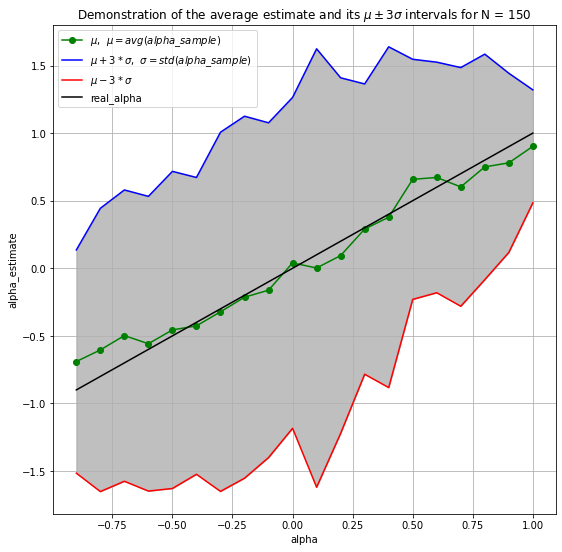

In [ ]:
N = sample_sizes[0]
num_samples = 50
Avg_Alpha_Estimates_e, Std_Alpha_Estimates_e = \
simulate_and_estimate(N, num_samples, projection_vectors, T, Alphas, 0)

values_of_alpha = Alphas
Means_500 = Avg_Alpha_Estimates_e
upper_line_500 = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line_500 = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means_500, upper_line_500, lower_line_500, N) 

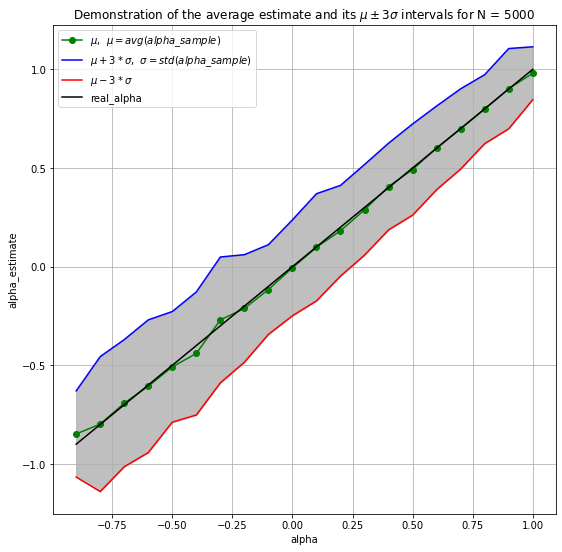

In [ ]:
N = sample_sizes[1]
num_samples = 50
Avg_Alpha_Estimates_e, Std_Alpha_Estimates_e = \
simulate_and_estimate(N, num_samples, projection_vectors, T, Alphas, 0)

values_of_alpha = Alphas
Means_5000 = Avg_Alpha_Estimates_e
upper_line_5000 = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line_5000 = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means_5000, upper_line_5000, lower_line_5000, N)   

Target alpha = -0.900, avg alpha_MLP_e = -0.900 
Target alpha = -0.800, avg alpha_MLP_e = -0.794 
Target alpha = -0.700, avg alpha_MLP_e = -0.698 
Target alpha = -0.600, avg alpha_MLP_e = -0.598 
Target alpha = -0.500, avg alpha_MLP_e = -0.502 
Target alpha = -0.400, avg alpha_MLP_e = -0.400 
Target alpha = -0.300, avg alpha_MLP_e = -0.300 
Target alpha = -0.200, avg alpha_MLP_e = -0.200 
Target alpha = -0.100, avg alpha_MLP_e = -0.100 
Target alpha = -0.000, avg alpha_MLP_e = -0.000 
Target alpha = 0.1000, avg alpha_MLP_e = 0.1000 
Target alpha = 0.2000, avg alpha_MLP_e = 0.2000 
Target alpha = 0.3000, avg alpha_MLP_e = 0.3000 
Target alpha = 0.4000, avg alpha_MLP_e = 0.4000 
Target alpha = 0.5000, avg alpha_MLP_e = 0.5000 
Target alpha = 0.6000, avg alpha_MLP_e = 0.6000 
Target alpha = 0.7000, avg alpha_MLP_e = 0.7000 
Target alpha = 0.8000, avg alpha_MLP_e = 0.8000 
Target alpha = 0.9000, avg alpha_MLP_e = 0.9020 
Target alpha = 1.0000, avg alpha_MLP_e = 1.0000 


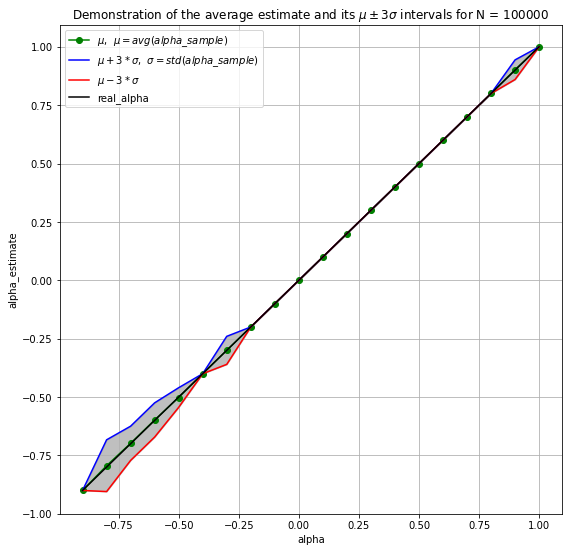

In [ ]:
N = sample_sizes[3]
num_samples = 50
Avg_Alpha_Estimates_e, Std_Alpha_Estimates_e = \
simulate_and_estimate(N, num_samples, projection_vectors, T, Alphas, 1)

values_of_alpha = Alphas
Means = Avg_Alpha_Estimates_e
upper_line = np.array(Avg_Alpha_Estimates_e) + 3*np.array(Std_Alpha_Estimates_e)
lower_line = np.array(Avg_Alpha_Estimates_e) - 3*np.array(Std_Alpha_Estimates_e)
visualize_samples(values_of_alpha, Means, upper_line, lower_line, N)  

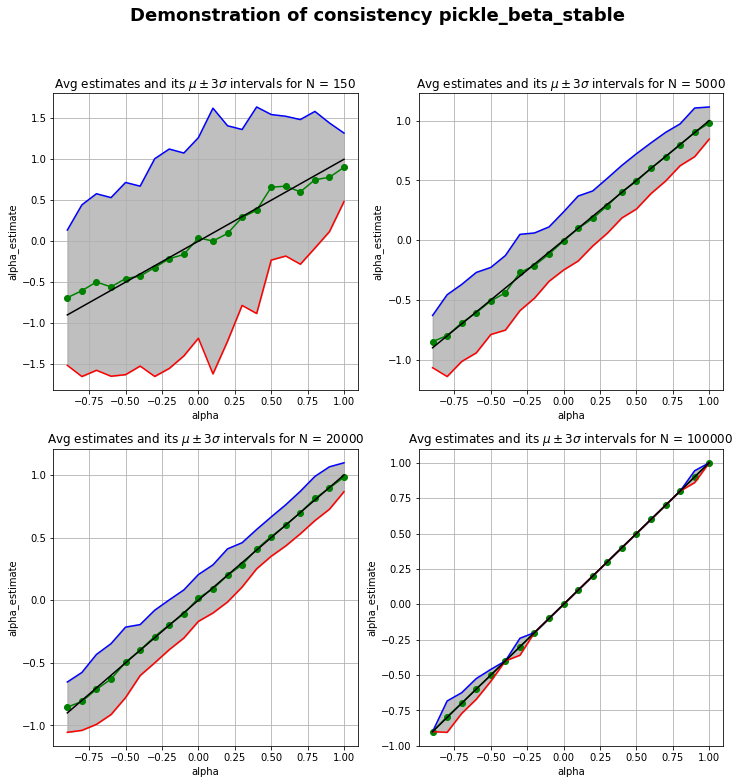

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

N = sample_sizes[0]

axs[0, 0].plot(values_of_alpha, Means_500, 'g-o')
axs[0, 0].plot(values_of_alpha, upper_line_500, 'b')
axs[0, 0].plot(values_of_alpha, lower_line_500, 'r')
axs[0, 0].plot(values_of_alpha, values_of_alpha, 'k')
axs[0, 0].fill_between(values_of_alpha, upper_line_500, lower_line_500, color='gray', alpha=0.5)
axs[0, 0].grid()
axs[0, 0].set_xlabel('alpha')
axs[0, 0].set_ylabel('alpha_estimate')
axs[0, 0].set_title(r'Avg estimates and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))

N = sample_sizes[1]
axs[0, 1].plot(values_of_alpha, Means_5000, 'g-o')
axs[0, 1].plot(values_of_alpha, upper_line_5000, 'b')
axs[0, 1].plot(values_of_alpha, lower_line_5000, 'r')
axs[0, 1].plot(values_of_alpha, values_of_alpha, 'k')
axs[0, 1].fill_between(values_of_alpha, upper_line_5000, lower_line_5000, color='gray', alpha=0.5)
axs[0, 1].grid()
axs[0, 1].set_xlabel('alpha')
axs[0, 1].set_ylabel('alpha_estimate')
axs[0, 1].set_title(r'Avg estimates and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))

N = sample_sizes[2]
axs[1, 0].plot(values_of_alpha, Means_100000, 'g-o')
axs[1, 0].plot(values_of_alpha, upper_line_100000, 'b')
axs[1, 0].plot(values_of_alpha, lower_line_100000, 'r')
axs[1, 0].plot(values_of_alpha, values_of_alpha, 'k')
axs[1, 0].fill_between(values_of_alpha, upper_line_100000, lower_line_100000, color='gray', alpha=0.5)
axs[1, 0].grid()
axs[1, 0].set_xlabel('alpha')
axs[1, 0].set_ylabel('alpha_estimate')
axs[1, 0].set_title(r'Avg estimates and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))

N = sample_sizes[3]
axs[1, 1].plot(values_of_alpha, Means, 'g-o')
axs[1, 1].plot(values_of_alpha, upper_line, 'b')
axs[1, 1].plot(values_of_alpha, lower_line, 'r')
axs[1, 1].plot(values_of_alpha, values_of_alpha, 'k')
axs[1, 1].fill_between(values_of_alpha, upper_line, lower_line, color='gray', alpha=0.5)
axs[1, 1].grid()
axs[1, 1].set_xlabel('alpha')
axs[1, 1].set_ylabel('alpha_estimate')
axs[1, 1].set_title(r'Avg estimates and its $\mu \pm 3 \sigma$ intervals for N = ' + str(N))
plt.suptitle('Demonstration of consistency '+storage[stor_j], fontsize=18, fontweight='bold')
plt.show()

In [ ]:
def mean_avg_differences(values_of_alpha, Means_500, upper_line_500, lower_line_500):
    mean_avg_diff = np.mean(np.abs(np.array(Means_500) - np.array(values_of_alpha)))
    mean_avg_diff_adj = np.mean(np.abs(np.array(Means_500) - np.array(values_of_alpha))*( np.array(upper_line_500) - np.array(lower_line_500) ))
    return mean_avg_diff, mean_avg_diff_adj

In [ ]:
mean_avg_diff_500, mean_avg_diff_adj_500 = mean_avg_differences(values_of_alpha, Means_500, upper_line_500, lower_line_500)
mean_avg_diff_5000, mean_avg_diff_adj_5000 = mean_avg_differences(values_of_alpha, Means_5000, upper_line_5000, lower_line_5000)
mean_avg_diff_100000, mean_avg_diff_adj_100000 = mean_avg_differences(values_of_alpha, Means_100000, upper_line_100000, lower_line_100000)
mean_avg_diff, mean_avg_diff_adj = mean_avg_differences(values_of_alpha, Means, upper_line, lower_line)

In [ ]:
print(f'For {storage[stor_j]} and N = {sample_sizes[0]}, abs_mean_diff     = {truncate_string(mean_avg_diff_500)}')
print(f'For {storage[stor_j]} and N = {sample_sizes[0]}, abs_mean_diff_adj = {truncate_string(mean_avg_diff_adj_500)}')
print('-------------------------------------------------------')
print(f'For {storage[stor_j]} and N = {sample_sizes[1]}, abs_mean_diff     = {truncate_string(mean_avg_diff_5000)}')
print(f'For {storage[stor_j]} and N = {sample_sizes[1]}, abs_mean_diff_adj = {truncate_string(mean_avg_diff_adj_5000)}')
print('-------------------------------------------------------')
print(f'For {storage[stor_j]} and N = {sample_sizes[2]}, abs_mean_diff     = {truncate_string(mean_avg_diff_100000)}')
print(f'For {storage[stor_j]} and N = {sample_sizes[2]}, abs_mean_diff_adj = {truncate_string(mean_avg_diff_adj_100000)}')
print('-------------------------------------------------------')
print(f'For {storage[stor_j]} and N = {sample_sizes[3]}, abs_mean_diff     = {truncate_string(mean_avg_diff)}')
print(f'For {storage[stor_j]} and N = {sample_sizes[3]}, abs_mean_diff_adj = {truncate_string(mean_avg_diff_adj)}')
print('-------------------------------------------------------')

For pickle_beta_stable and N = 150, abs_mean_diff     = 0.0845
For pickle_beta_stable and N = 150, abs_mean_diff_adj = 0.1683
-------------------------------------------------------
For pickle_beta_stable and N = 5000, abs_mean_diff     = 0.0127
For pickle_beta_stable and N = 5000, abs_mean_diff_adj = 0.0064
-------------------------------------------------------
For pickle_beta_stable and N = 20000, abs_mean_diff     = 0.0113
For pickle_beta_stable and N = 20000, abs_mean_diff_adj = 0.0046
-------------------------------------------------------
For pickle_beta_stable and N = 100000, abs_mean_diff     = 0.0007
For pickle_beta_stable and N = 100000, abs_mean_diff_adj = 0.0001
-------------------------------------------------------
